# Import des bibliothèques

In [406]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from kneed import KneeLocator
import itertools

# Nettoyage des données

In [407]:
# Charger le fichier CSV dans un dataframe Pandas
df = pd.read_csv('/home/clementine/Documents/10-OLIST/clustering_parcour_customers_202304131631.csv', delimiter=',', quotechar='"')

In [408]:
df.shape

(99441, 12)

In [409]:
df.head(n=10)

,order_id,customer_id,order_purchase_timestamp,approvement_time,carrier_deliver_time,customer_deliver_time,first_review_after_delivery,gap_estimated_delivery,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02.000,00:00:00,6 days,7 days,00:00:00,-8 days,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31.000,00:00:00,1 day,7 days,00:00:00,-13 days,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
2,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35.000,00:00:00,2 days,6 days,00:00:00,-5 days,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
3,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51.000,00:00:00,11 days,25 days,00:00:00,-15 days,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP
4,00048cc3ae777c65dbb7d2a0634bc1ea,816cbea969fe5b689b39cfc97a506742,2017-05-15 21:42:34.000,1 day,1 day,6 days,00:00:00,-14 days,85c835d128beae5b4ce8602c491bf385,38017,uberaba,MG
5,00054e8431b9d7675808bcb819fb4a32,32e2e6ab09e778d99bf2e0ecd4898718,2017-12-10 11:53:48.000,00:00:00,1 day,8 days,00:00:00,-16 days,635d9ac1680f03288e72ada3a1035803,16700,guararapes,SP
6,000576fe39319847cbb9d288c5617fa6,9ed5e522dd9dd85b4af4a077526d8117,2018-07-04 12:08:27.000,1 day,1 day,5 days,00:00:00,-15 days,fda4476abb6307ab3c415b7e6d026526,11702,praia grande,SP
7,00061f2a7bc09da83e415a52dc8a4af1,c6fc061d86fab1e2b2eac259bac71a49,2018-03-24 22:16:10.000,00:00:00,2 days,4 days,00:00:00,-10 days,107e6259485efac66428a56f10801f4f,13419,piracicaba,SP
8,0008288aa423d2a3f00fcb17cd7d8719,2355af7c75e7c98b43a87b2a7f210dc5,2018-02-13 22:10:21.000,1 day,6 days,12 days,00:00:00,-7 days,9e4159995424971423b98c4a8bc11529,6600,jandira,SP
9,0009792311464db532ff765bf7b182ae,2a30c97668e81df7c17a8b14447aeeba,2018-08-14 20:43:09.000,00:00:00,00:00:00,7 days,00:00:00,-5 days,4987996ddcd0ddb20740fdce7c2bfbb1,37137,alfenas,MG


In [410]:
#remove not necessery columns and empty data
df = df.drop(['customer_city', 'customer_zip_code_prefix','customer_id', 'customer_unique_id', 'order_purchase_timestamp', 'order_id', 'customer_state'], axis=1)
df = df.dropna()

In [411]:
df.shape

(95815, 5)

In [412]:
#transform time to integer
for col in ['carrier_deliver_time', 'customer_deliver_time', 'gap_estimated_delivery', 'approvement_time', 'first_review_after_delivery']:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds().astype(int)

In [413]:
df.head(n=10)

,approvement_time,carrier_deliver_time,customer_deliver_time,first_review_after_delivery,gap_estimated_delivery
0,0,518400,604800,0,-691200
1,0,86400,604800,0,-1123200
2,0,172800,518400,0,-432000
3,0,950400,2160000,0,-1296000
4,86400,86400,518400,0,-1209600
5,0,86400,691200,0,-1382400
6,86400,86400,432000,0,-1296000
7,0,172800,345600,0,-864000
8,86400,518400,1036800,0,-604800
9,0,0,604800,0,-432000


In [414]:
#convert seconds to day
cols_to_convert = ['carrier_deliver_time', 'customer_deliver_time', 'gap_estimated_delivery', 'approvement_time', 'first_review_after_delivery']
df[cols_to_convert] = df[cols_to_convert].apply(lambda x: x / 86400)

In [435]:
df.head(n=10)

,approvement_time,carrier_deliver_time,customer_deliver_time,first_review_after_delivery,gap_estimated_delivery,cluster
0,0,6,7,0,-8,0
1,0,1,7,0,-13,0
2,0,2,6,0,-5,0
3,0,11,25,0,-15,1
4,1,1,6,0,-14,0
5,0,1,8,0,-16,2
6,1,1,5,0,-15,0
7,0,2,4,0,-10,0
8,1,6,12,0,-7,0
9,0,0,7,0,-5,0


### df.head(n=10)

In [415]:
df[['carrier_deliver_time', 'customer_deliver_time', 'gap_estimated_delivery', 'approvement_time', 'first_review_after_delivery']] = df[['carrier_deliver_time', 'customer_deliver_time', 'gap_estimated_delivery', 'approvement_time', 'first_review_after_delivery']].applymap(lambda x: int(x) if not pd.isnull(x) else x)

In [416]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95815 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   approvement_time             95815 non-null  int64
 1   carrier_deliver_time         95815 non-null  int64
 2   customer_deliver_time        95815 non-null  int64
 3   first_review_after_delivery  95815 non-null  int64
 4   gap_estimated_delivery       95815 non-null  int64
dtypes: int64(5)
memory usage: 4.4 MB


# Preprocessing

In [417]:
#df = pd.get_dummies(df, columns=['customer_state'], prefix='state')

In [418]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df)

In [419]:
inertias = []
for k in range(3, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

In [420]:
# Mesure de qualité de la clustering
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
print('Silhouette Score:', silhouette_avg)

Silhouette Score: 0.27358718173883645


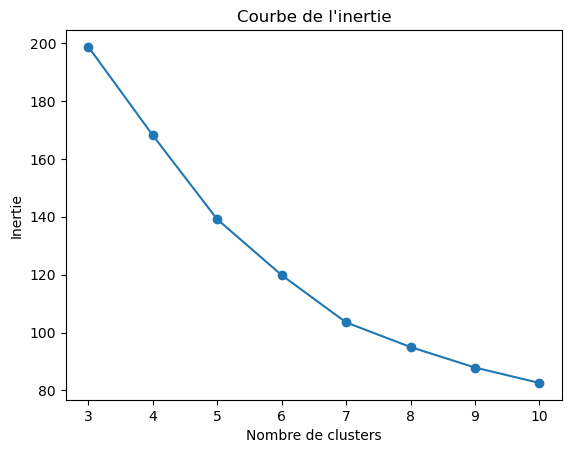

In [421]:
plt.plot(range(3, 11), inertias, marker='o')
plt.title('Courbe de l\'inertie')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.show()

In [422]:
# Recherche du meilleur k
kl = KneeLocator(range(3, 11), inertias, curve='convex', direction='decreasing')
best_k = kl.elbow

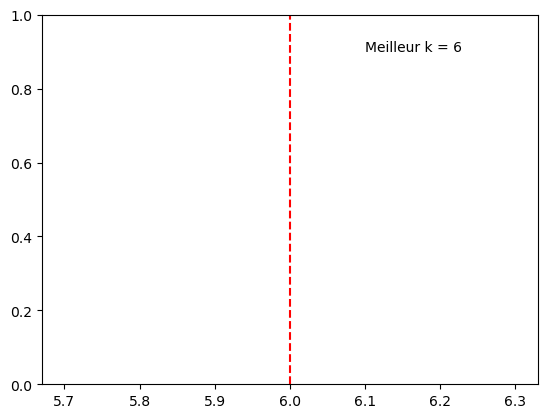

In [423]:
# Affichage du meilleur k
plt.axvline(x=best_k, color='r', linestyle='--')
plt.text(best_k+0.1, plt.ylim()[1]*0.9, f"Meilleur k = {best_k}", fontsize=10)

plt.show()

In [424]:
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

In [425]:
print('Nombre de clients dans chaque cluster:', np.bincount(labels))
print('Score de silhouette :', silhouette_score(X_scaled, labels))

Nombre de clients dans chaque cluster: [43040 21860 22981    74  3376  4484]
Score de silhouette : 0.29385082573450005


In [426]:
# Assigner les labels des clusters aux données
labels = kmeans.labels_

In [427]:
# Ajouter les labels des clusters au dataframe
df['cluster'] = labels
df

,approvement_time,carrier_deliver_time,customer_deliver_time,first_review_after_delivery,gap_estimated_delivery,cluster
0,0,6,7,0,-8,0
1,0,1,7,0,-13,0
2,0,2,6,0,-5,0
3,0,11,25,0,-15,1
4,1,1,6,0,-14,0
...,...,...,...,...,...,...
99436,1,1,17,0,-7,1
99437,2,2,9,0,-8,5
99438,1,2,4,0,-12,0
99439,0,0,1,0,-8,0


In [428]:
# Identifier les caractéristiques principales de chaque cluster
cluster_features = df.groupby(['cluster']).mean()

In [429]:
# Afficher les caractéristiques principales de chaque cluster
print(cluster_features)

         approvement_time  carrier_deliver_time  customer_deliver_time  \
cluster                                                                  
0                0.113569              1.792356               6.867519   
1                0.188152              4.289982              19.824016   
2                0.122362              2.051782               9.579870   
3                0.202703              8.837838             134.716216   
4                0.297097              6.861671              41.608412   
5                2.786798              4.425067              12.324041   

         first_review_after_delivery  gap_estimated_delivery  
cluster                                                       
0                           0.080994               -9.969912  
1                          -0.203980               -6.144007  
2                           0.156956              -21.400896  
3                        -106.000000              106.932432  
4                         -11

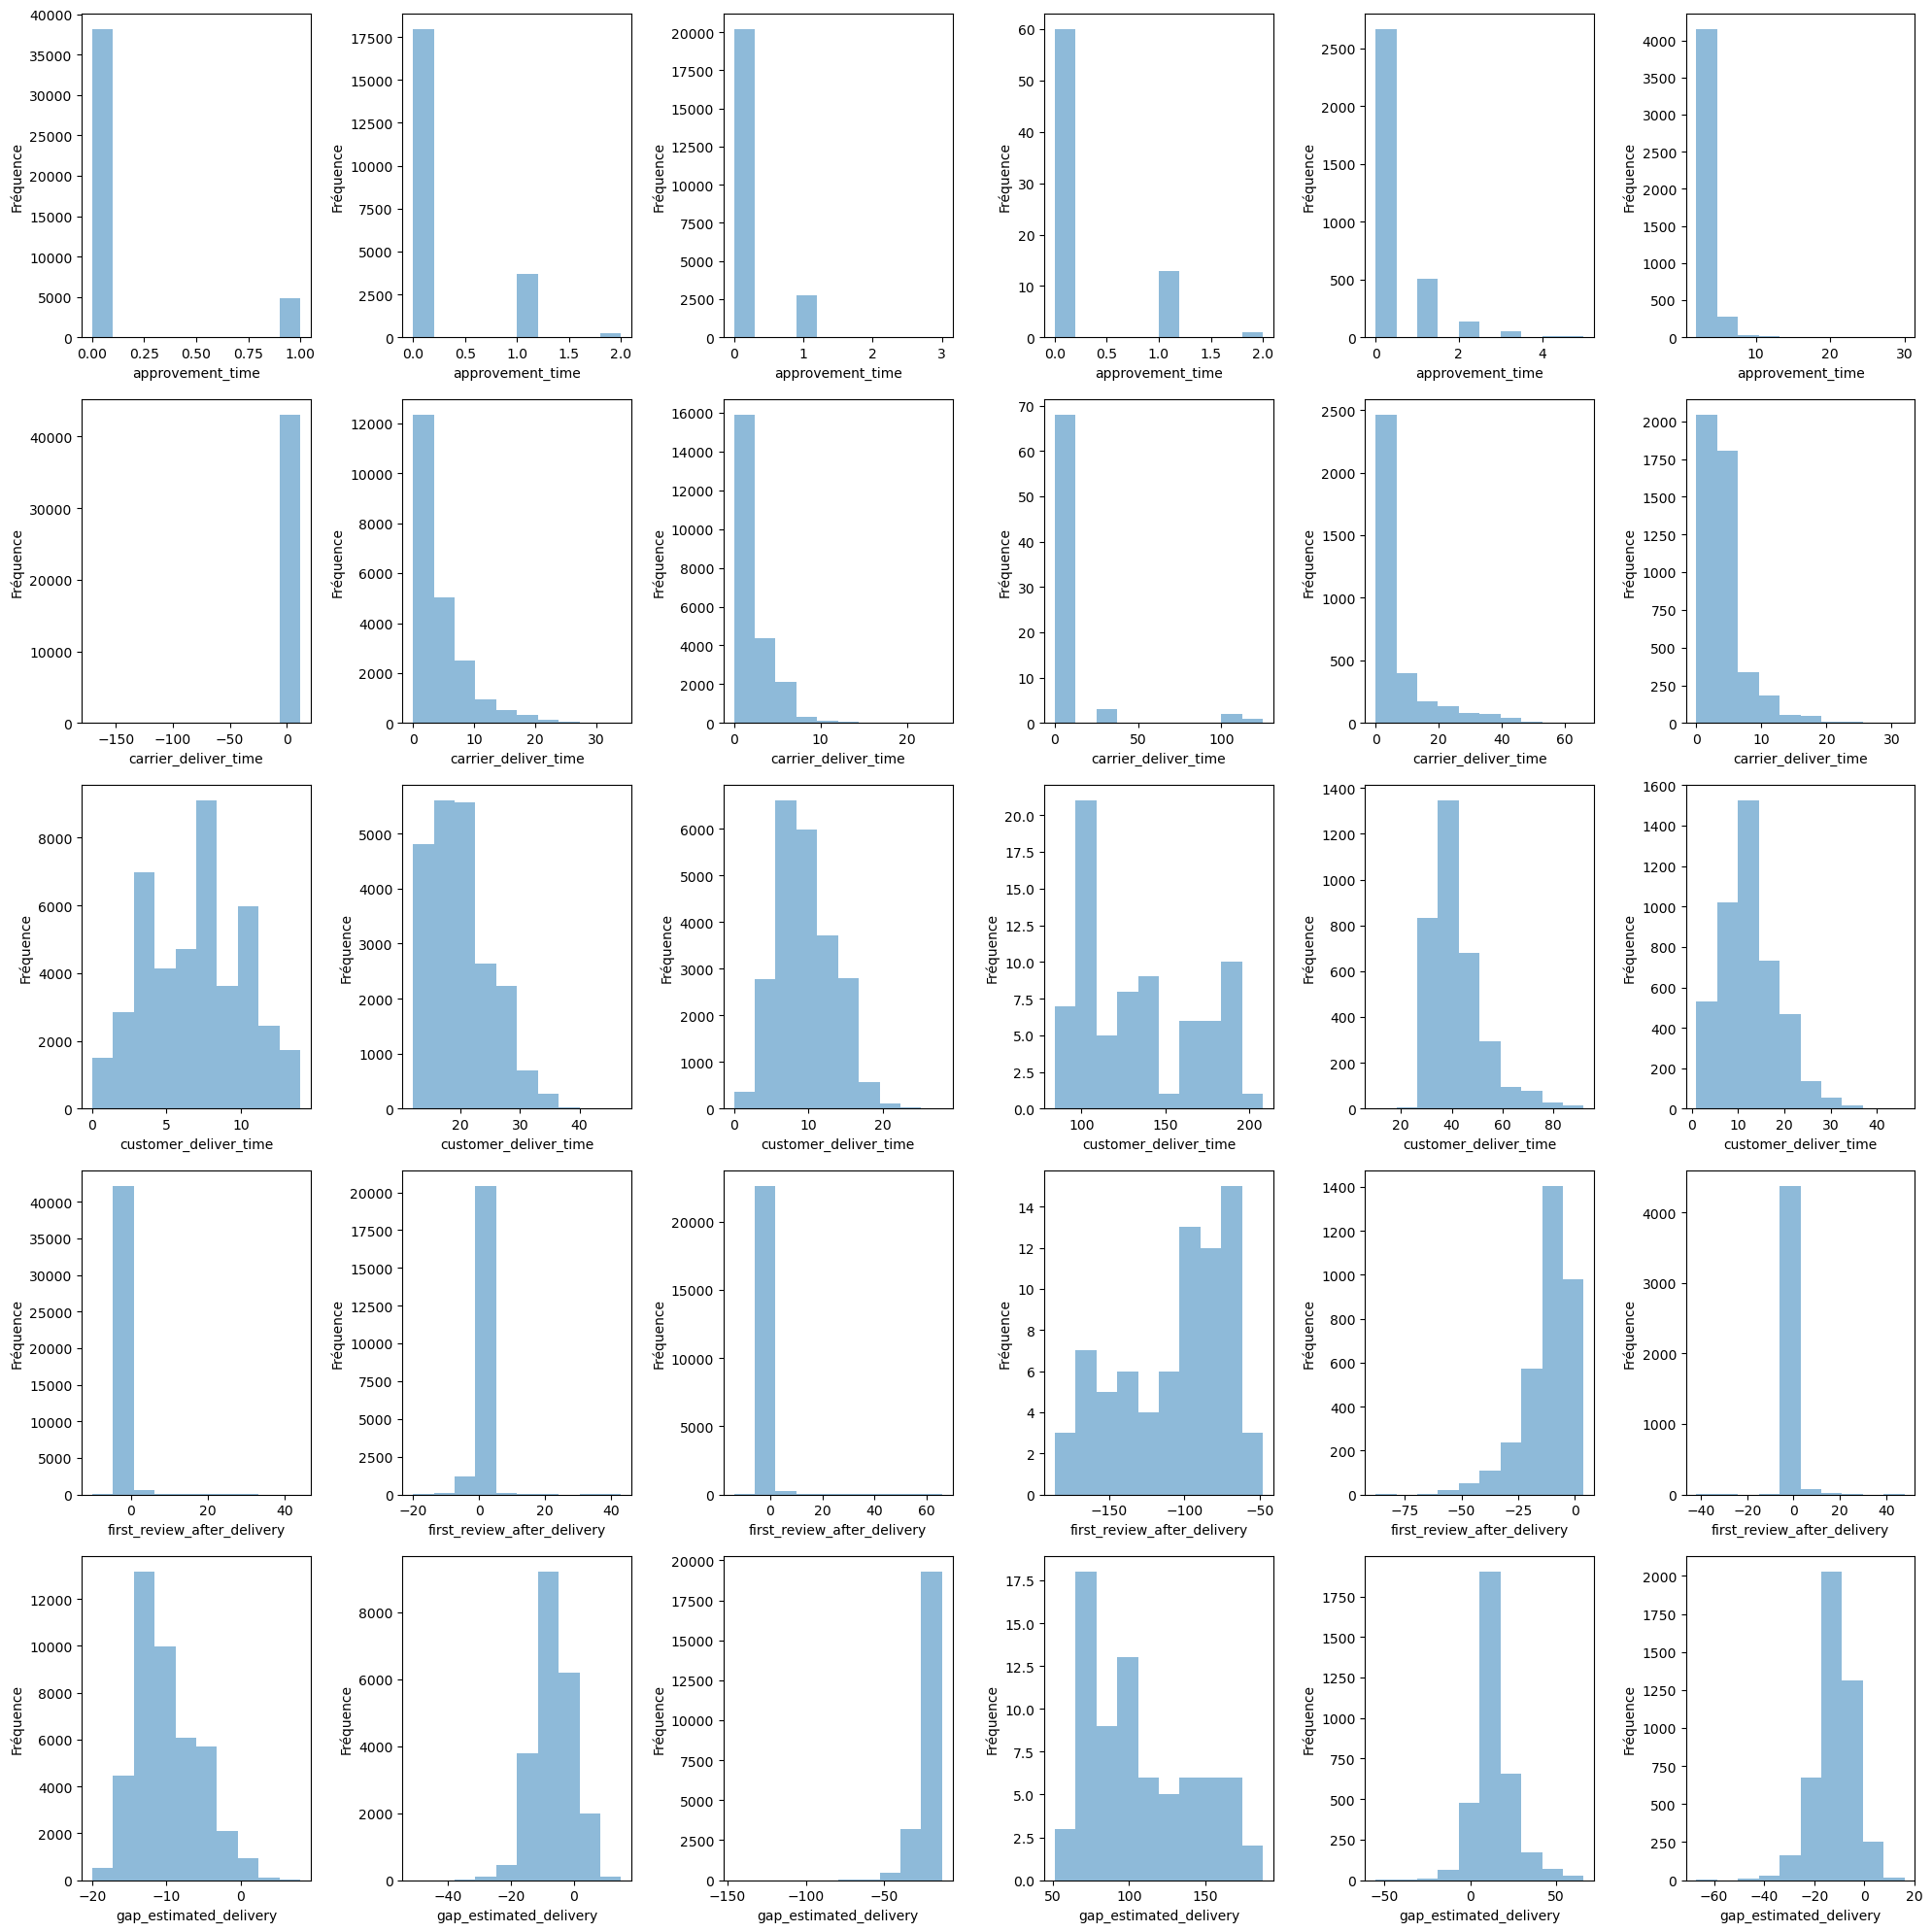

In [430]:
# Visualiser la distribution des variables pour chaque cluster
fig, axes = plt.subplots(nrows=len(cluster_features.columns), ncols=len(cluster_features), figsize=(20,20))
for i, col in enumerate(cluster_features.columns):
    for j in range(len(cluster_features)):
        axes[i,j].hist(df[df['cluster']==j][col], alpha=0.5)
        axes[i,j].set_xlabel(col)
        axes[i,j].set_ylabel('Fréquence')
plt.tight_layout()
plt.show()

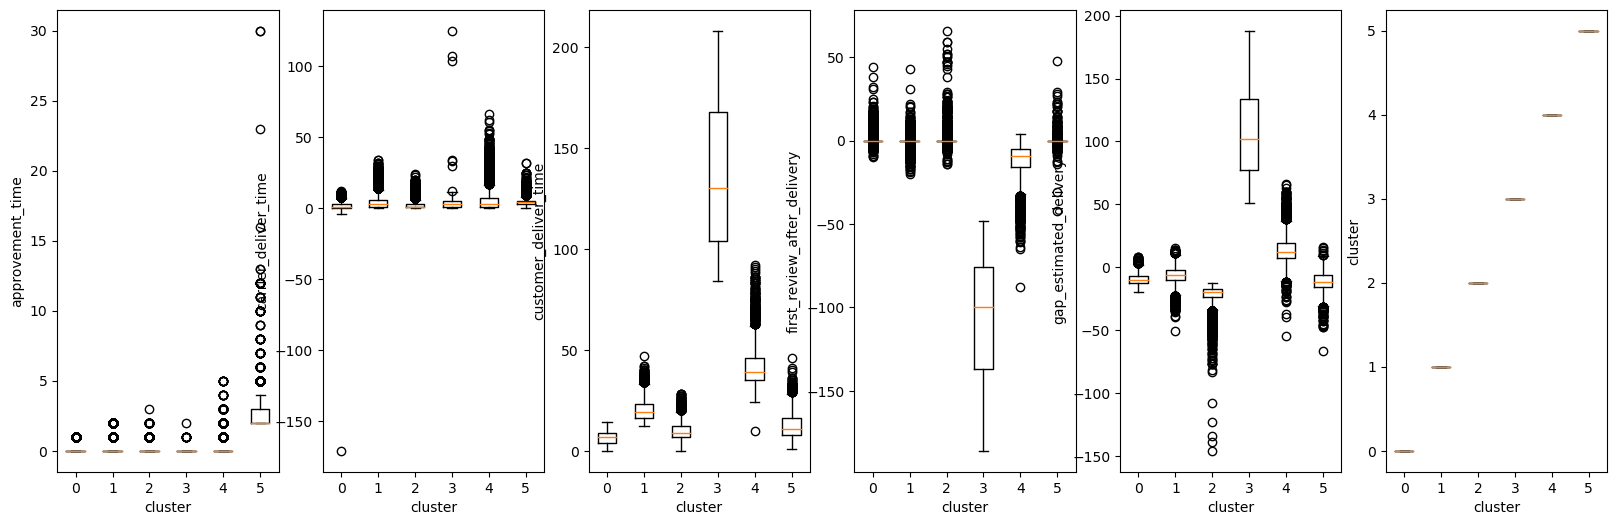

In [432]:
#boite à moustaches
fig, axes = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(20,6))
for i, col in enumerate(df.columns):
    axes[i].boxplot([cluster_df.loc[cluster_df['cluster']==j, col] for j in range(len(cluster_means))])
    axes[i].set_xlabel('cluster')
    axes[i].set_ylabel(col)
    axes[i].set_xticklabels(range(len(cluster_means)))
    
plt.show()

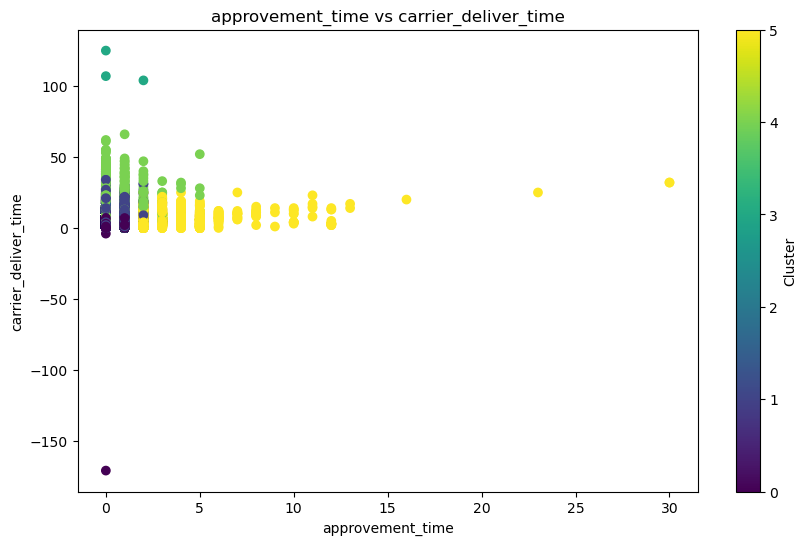

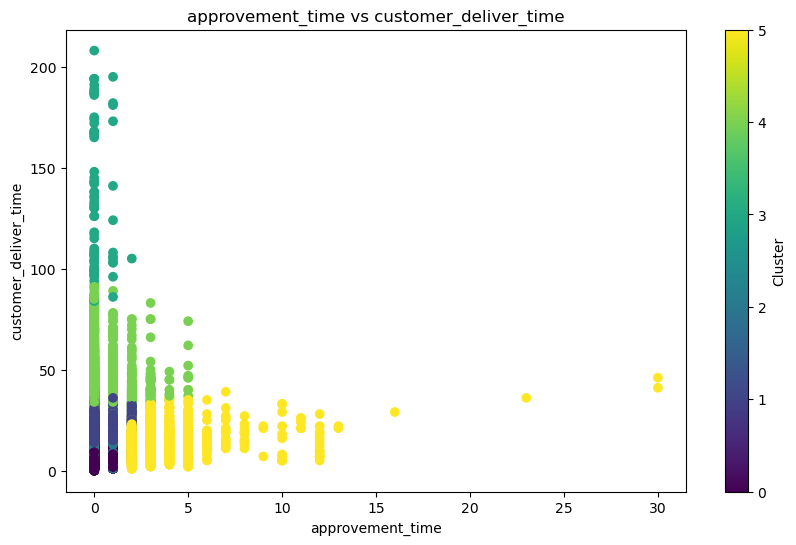

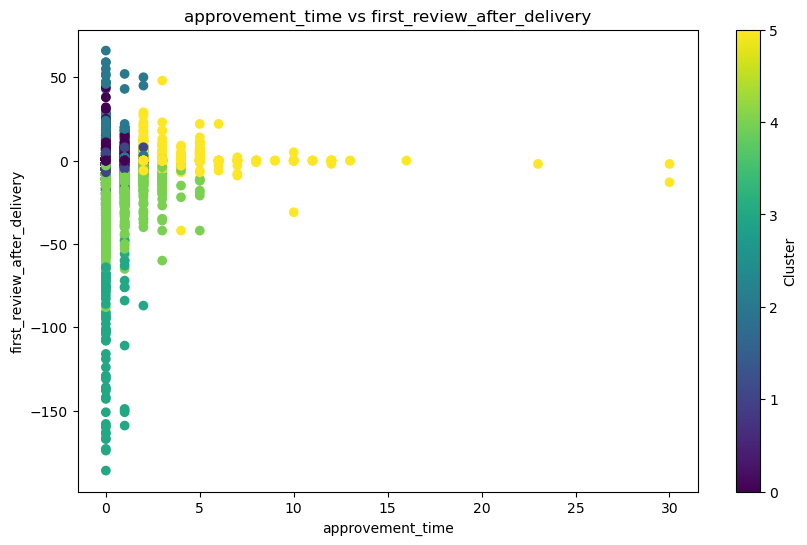

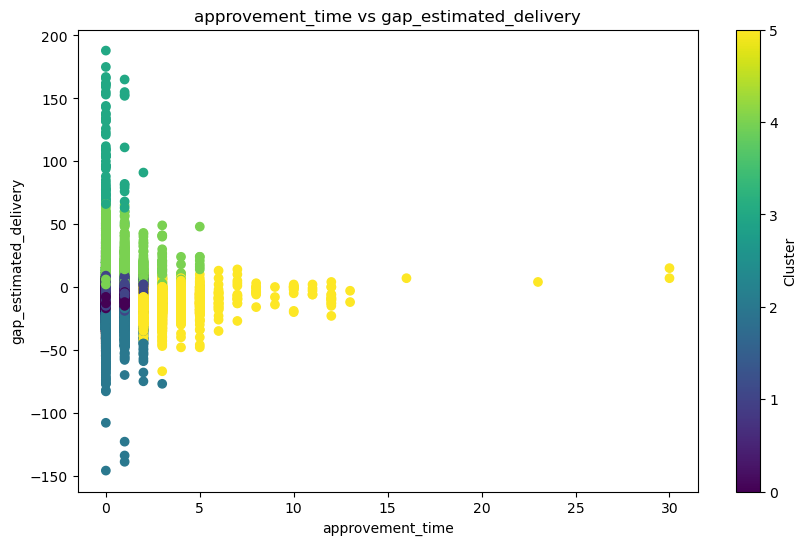

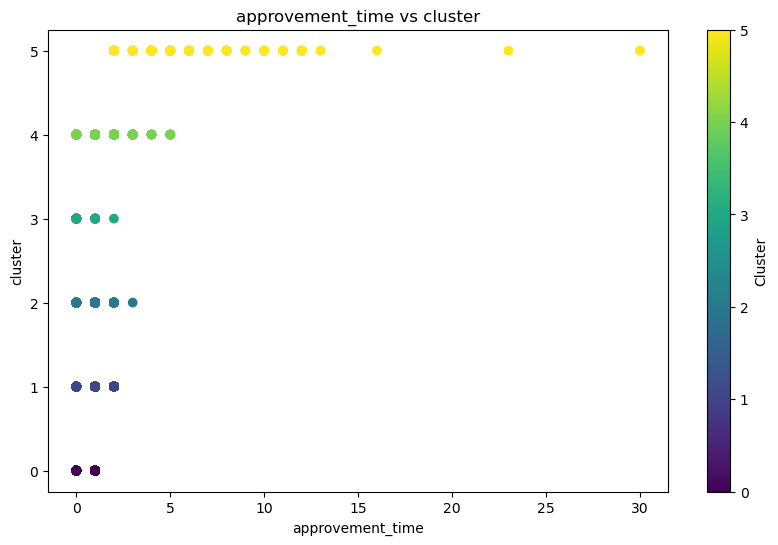

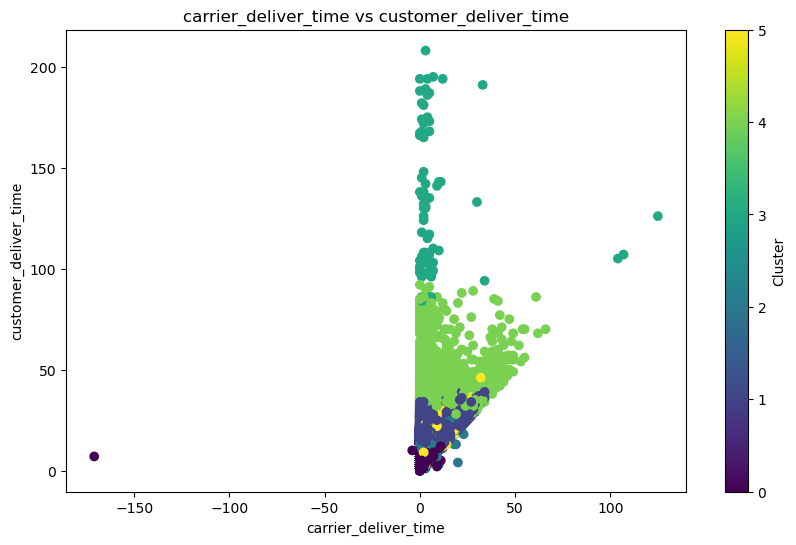

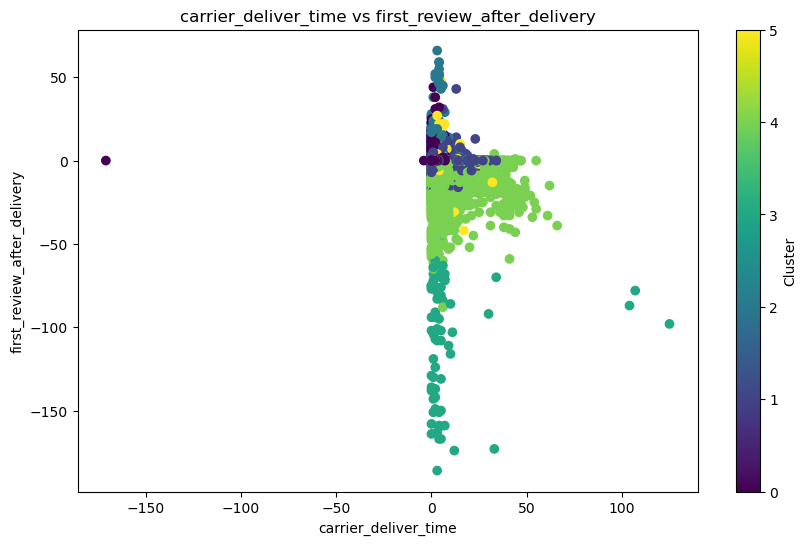

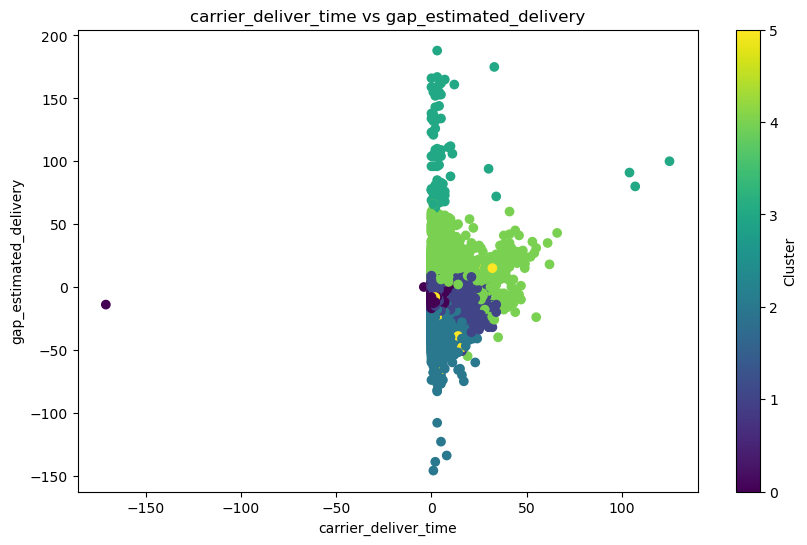

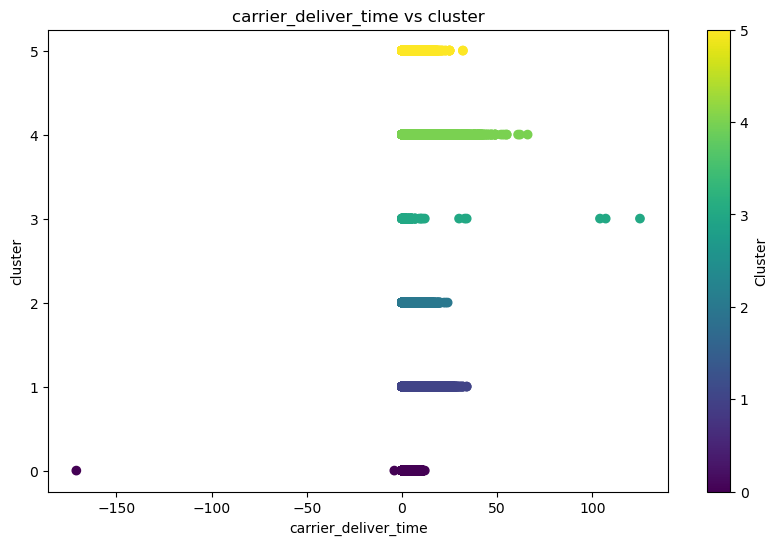

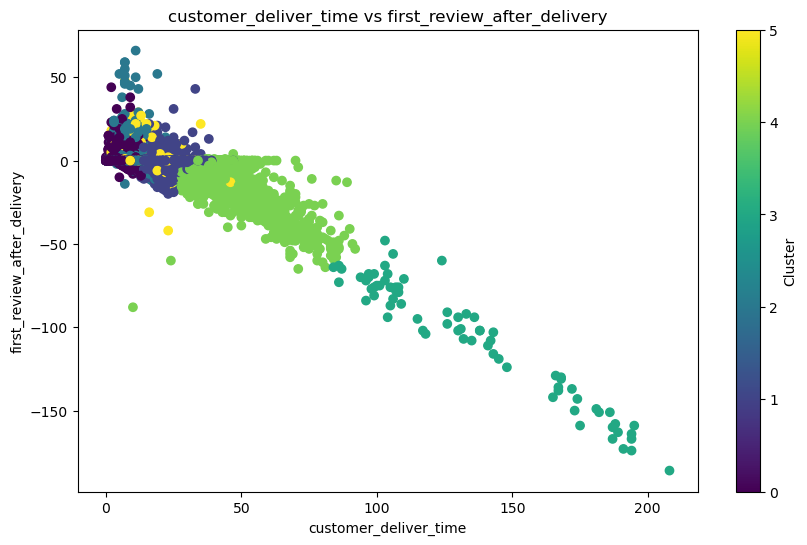

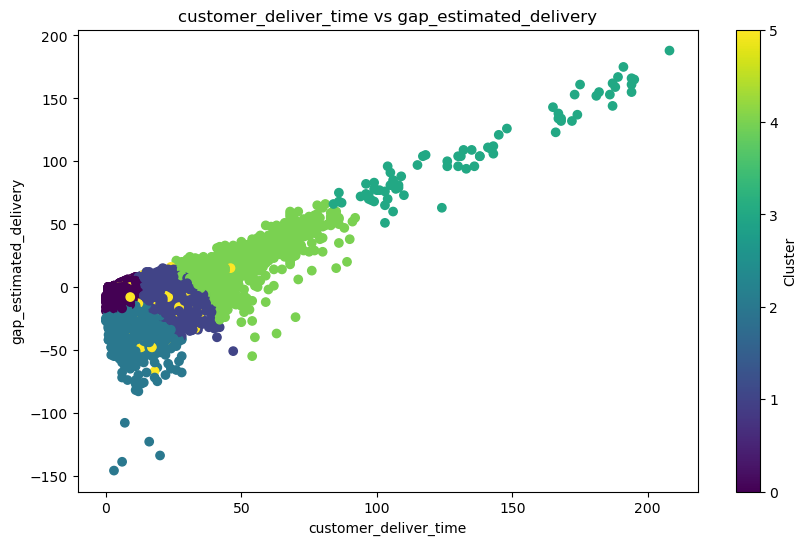

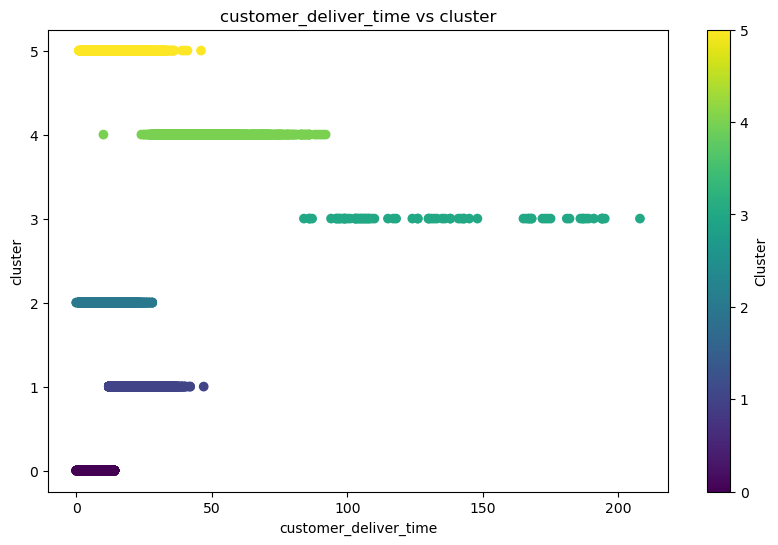

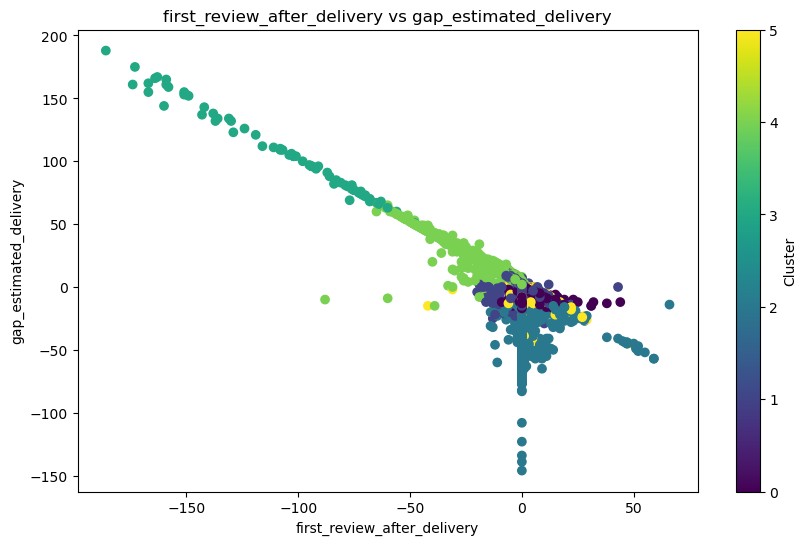

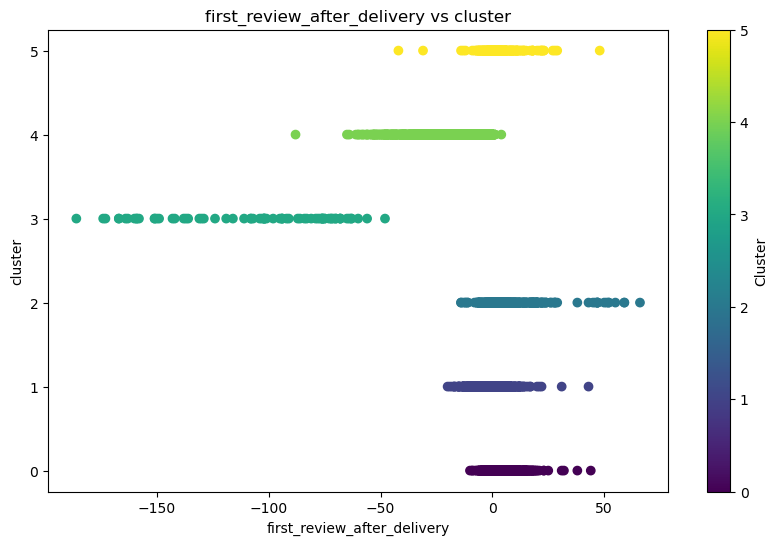

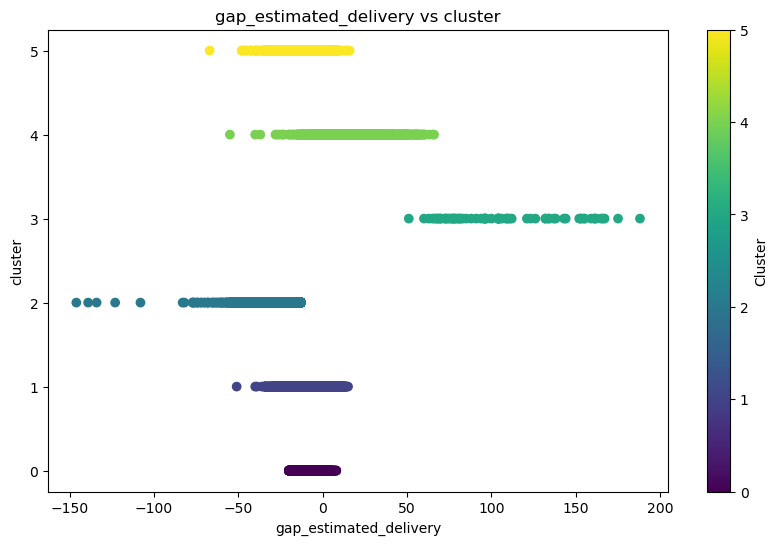

In [433]:
# Obtention de toutes les combinaisons possibles de paires de variables
combinations = list(itertools.combinations(df.columns, 2))

# Affichage de chaque combinaison sous forme de scatter plot avec coloration par cluster et légende
for comb in combinations:
    plt.figure(figsize=(10, 6))
    plt.scatter(df[comb[0]], df[comb[1]], c=df['cluster'], cmap='viridis')
    plt.xlabel(comb[0])
    plt.ylabel(comb[1])
    plt.title(f"{comb[0]} vs {comb[1]}")
    plt.colorbar(label='Cluster')
    plt.show()

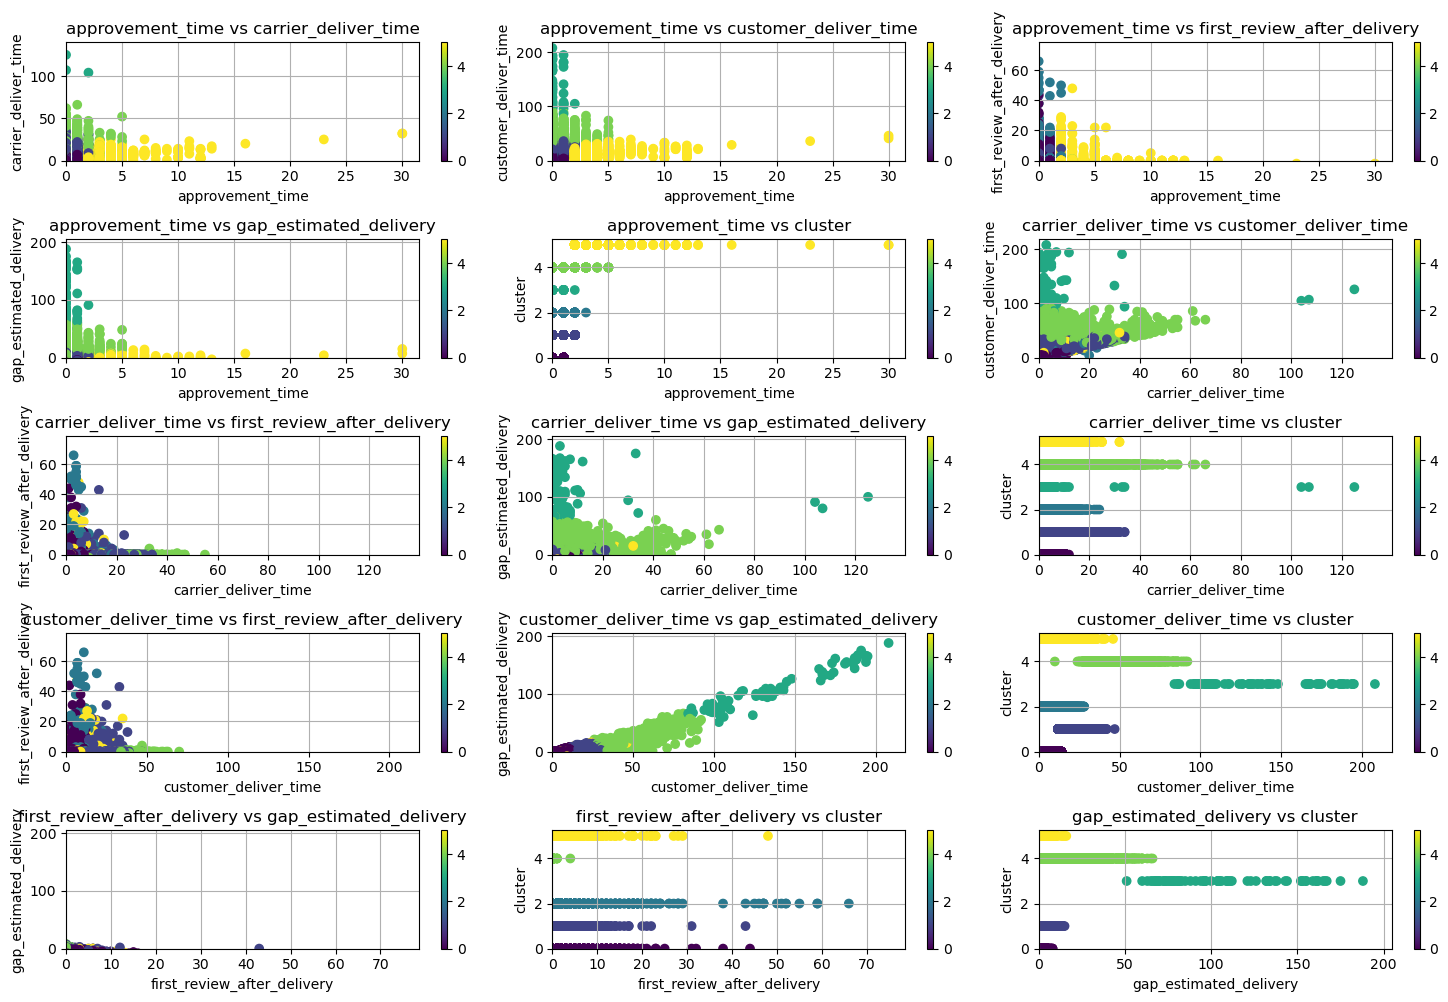

In [434]:
# Obtention de toutes les combinaisons possibles de paires de variables
combinations = list(itertools.combinations(df.columns, 2))

# Création d'une matrice de scatter plots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Pour chaque combinaison, tracer un scatter plot dans la matrice
for i, comb in enumerate(combinations):
    axes[i].scatter(df[comb[0]], df[comb[1]], c=df['cluster'], cmap='viridis')
    axes[i].set_xlabel(comb[0])
    axes[i].set_ylabel(comb[1])
    axes[i].set_title(f"{comb[0]} vs {comb[1]}")
    axes[i].set_xlim(left=0)
    axes[i].set_ylim(bottom=0)
    axes[i].grid(True)
    fig.colorbar(axes[i].collections[0], ax=axes[i])

# Affichage de la matrice de scatter plots
plt.tight_layout()
plt.show()